# Generate Data

In [1]:
import sys
sys.path.append("../MLTSA_2D_DATA_GENERATION")
from TwoD_pot_data import *
from matplotlib import pyplot as plt

  0%|          | 0/100 [00:00<?, ?it/s]

Some useful functions has been defined in ahead, set help=True for details


100%|██████████| 100/100 [00:13<00:00,  7.31it/s]


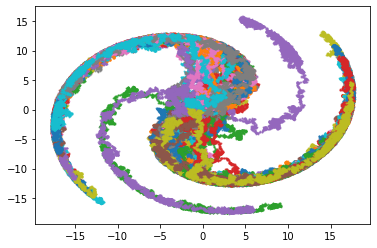

In [2]:
raw_s2 = generate_traj('s2', number=100, visual=True)

Text(0.5, 1.0, 'Origional Trajectories')

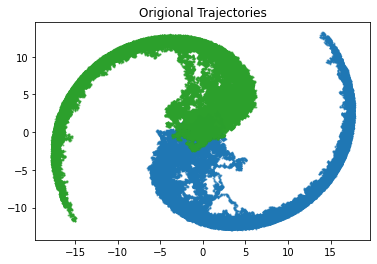

In [3]:
dp_s2 = data_processor('s2')
data_s2, label_s2 = data_process_full(dp_s2, raw_s2, 25, True)
plt.title("Origional Trajectories")


The output result shape is set as (n_samples, n_features, n_steps)


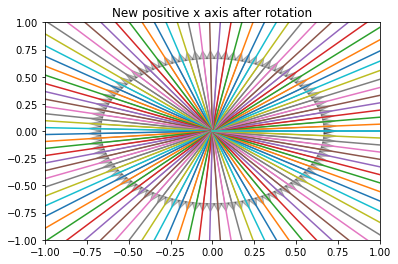

In [4]:
p_100 = data_projector("grid")
p_100.show_axis()
projs = p_100.batch_rotation(data_s2)

In [5]:
data, labels = projs, label_s2 # Data Prepared

# Process Data

In [6]:
from MLTSA_Lite.MLTSA_sk import (
    MLTSA as MLTSA_skl,
    MLTSA_Plot as MLTSA_plot_sk,
)

from MLTSA_Lite.models import SKL_Train
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neural_network import MLPClassifier
from LRP import *
from sklearn.model_selection import train_test_split

In [7]:
HIDDEN_SHAPE = (200,200)

In [8]:
# Data Process for MLTSA Process
time_start = 100
time_end = 500
time_length = time_end - time_start

replica_num = 1
data = data.repeat(replica_num,axis=0)
labels = labels.repeat(replica_num,axis=0)

tmp_data = data[:,:,time_start:time_end]
tmp_data = np.transpose(tmp_data, [1,0,2])
tmp_data.shape

(100, 50, 400)

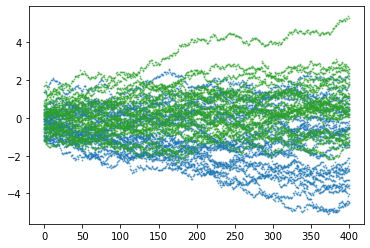

In [9]:
import matplotlib.pyplot as plt
feature_id = 2
for i in range(len(labels)):
    plt.plot(data[i,feature_id, time_start:time_end], color=f'C{labels[i]}', marker='o', lw=0, markersize=1, alpha=0.5)

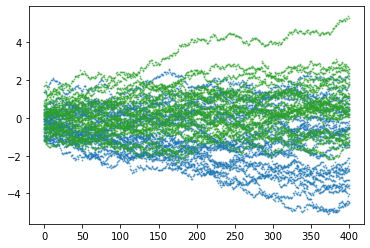

In [10]:
import matplotlib.pyplot as plt
feature_id = 2
for i in range(len(labels)):
    plt.plot(tmp_data[feature_id][i], color=f'C{labels[i]}', marker='o', lw=0, markersize=1, alpha=0.5)

In [11]:
mlp_labels = labels.repeat(time_end-time_start)

In [12]:
#mlp_data = np.concatenate(tmp_data.T, axis=0).T
mlp_data = np.concatenate(np.transpose(tmp_data,(1,2,0)), axis=0).T
mlp_data.shape

(100, 20000)

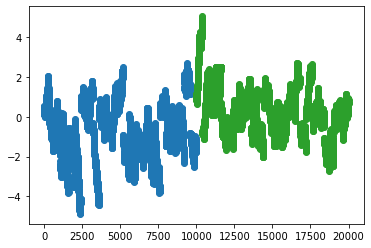

In [13]:
for index in range(len(mlp_data[0])):

    plt.plot(index, mlp_data[0][index], marker='o', lw=0,c="C{}".format(mlp_labels[index]))

In [14]:
len(mlp_labels)

20000

In [15]:
mlp_data.shape

(100, 20000)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(mlp_data.T, np.array(mlp_labels))

In [17]:
X_train.shape, y_train.shape

((15000, 100), (15000,))

In [18]:
from sklearn.neural_network import MLPClassifier

In [19]:
Deep_NN = MLPClassifier(random_state=1, verbose=False, max_iter=500,hidden_layer_sizes=(HIDDEN_SHAPE)) # You can set the verbose to false for less prints.
NN = MLPClassifier(random_state=1, verbose=False, max_iter=500)
trained_NN, train_acc, test_acc = SKL_Train(Deep_NN, X_train, y_train)

Accuracy on Train is 80.85333333333334
Accuracy on Test set is 80.02666666666667
Trained in  13.822643280029297 seconds


In [20]:
trained_NN.score(X_test, y_test)

0.805

In [21]:
model_summary(trained_NN)

Number of Coefs (layer):  3
[(100, 200), (200, 200), (200, 1)]
Number of Intercepts (layer):  3
[(200,), (200,), (1,)]
Hidden layer activation function :  relu
Output layer activation function :  logistic


In [22]:
data.shape

(50, 100, 10000)

In [23]:
ADrop_train_avg = MLTSA_skl(data[:,:,time_start:time_end], labels, trained_NN, drop_mode="Average")

50it [00:04, 12.06it/s]


In [24]:
ADrop_train_avg.shape

(100,)

In [25]:
relevance = LRP_eps_nb(trained_NN, X_test[-2])
print(relevance[-1])

  0%|          | 0/200 [00:00<?, ?it/s]

Append hidden
Append hidden
Appedn output


100%|██████████| 100/100 [00:02<00:00, 38.48it/s]

[0.00022357]


In [26]:
relevance[-1]

array([0.00022357])

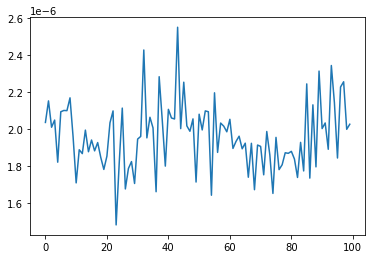

In [27]:
plt.plot(relevance[0])

0.805
[0.00022357]


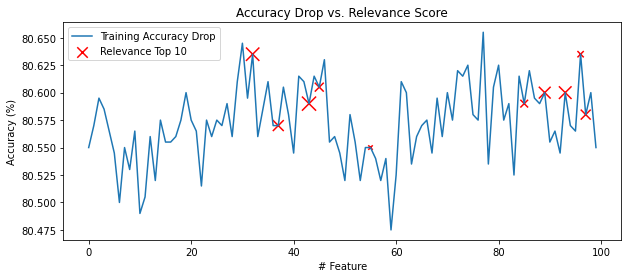

In [28]:
# Number of top relevance score
num = 10
top_num_LRP = np.argsort(relevance[0])[-num:]
# Plot of Accuracy Drop vs. Relevance Score
plt.figure(figsize=(10,4))
plt.plot(ADrop_train_avg*100, label="Training Accuracy Drop", color="C0")
plt.scatter(top_num_LRP, (ADrop_train_avg*100)[top_num_LRP], marker="x", color='r', label="Relevance Top {}".format(num), s=list(range(20,20*(num+1),20)))
plt.legend()
plt.title("Accuracy Drop vs. Relevance Score")
plt.xlabel("# Feature")
plt.ylabel("Accuracy (%)")
print(trained_NN.score(X_test, y_test))
print(relevance[-1])

# Test of Jaccard Index

In [29]:
import numpy as np

def quickJaccard(data1, data2):
    """
    A function calculating the overlap for two datasets
    """
    # 1. The overlap range judging
    left = np.min(np.where(np.max(data1) == np.max([data1, data2]), data1, data2))
    right = np.max(np.where(np.min(data1) == np.min([data1, data2]), data1, data2))
    #print(left,right)
    # 2. Pre-Judge if overlap range is empty
    if left > right:
        return 0 # No overlap, hence no common items, Jaccard Index is zero now
    # 3. Counting overlap items
    joinList = sorted(np.concatenate([data1, data2])) # sorted whole list of data

    count = 0 # init count to zero
    for point in joinList:
        if point < right: # Judge the upper cap
            if point > left: # Judge the lower cap
                count += 1
        else:
            break # Stop iteration if exceed upper cap
    #print(count)
    return count/len(joinList) # JaccardIndex: #InterceptionSet / #UnionSet

In [30]:
tmp_data.shape

(100, 50, 400)

In [31]:
labels[250:]

array([], dtype=int64)

In [32]:
from tqdm import tqdm
JI = []
for index in tqdm(range(len(tmp_data))):
    data1 = np.concatenate(tmp_data[index,:25*replica_num].T, axis=0) # Data of label 0
    data2 = np.concatenate(tmp_data[index,25*replica_num:].T, axis=0) # Data of label 1
    JI.append(quickJaccard(data1, data2))

100%|██████████| 100/100 [00:00<00:00, 108.71it/s]


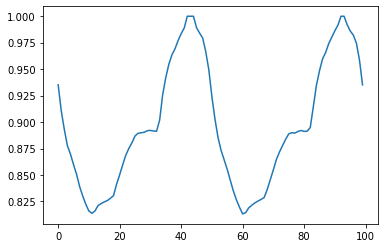

In [33]:
plt.plot(JI)

In [34]:
JI_top_10 = np.argsort(JI)[-10:]

0.805
[0.00022357]


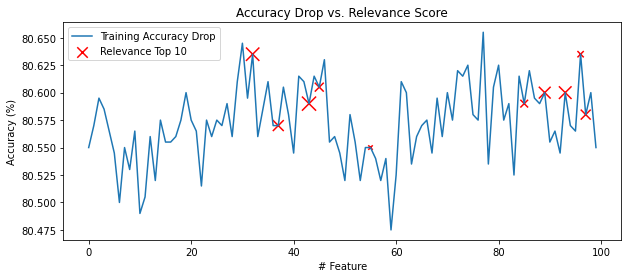

In [35]:
# Number of top relevance score
num = 10
top_num_LRP = np.argsort(relevance[0])[-num:]
# Plot of Accuracy Drop vs. Relevance Score
plt.figure(figsize=(10,4))
plt.plot(ADrop_train_avg*100, label="Training Accuracy Drop", color="C0")
plt.scatter(top_num_LRP, (ADrop_train_avg*100)[top_num_LRP], marker="x", color='r', label="Relevance Top {}".format(num), s=list(range(20,20*(num+1),20)))
plt.legend()
plt.title("Accuracy Drop vs. Relevance Score")
plt.xlabel("# Feature")
plt.ylabel("Accuracy (%)")
print(trained_NN.score(X_test, y_test))
print(relevance[-1])

In [36]:
def MLCorrPlot2D(CorrList, scoreA, scoreB, topN=10, isDrop=True, fullRank=True):
    """CorrPlot showing the correlation between two scoring method to one dataframe

    :param CorrList: List of computed correlations of the feature to the target, in shape of (n_features)
    :type CorrList: numpy.array
    :param scoreA: dataA input as score of some criteria
    :type scoreA: numpy.array
    :param scoreB: dataB input as score of some criteria, could be drop(see isDrop)
    :type scoreB: numpy.ndarray
    :param topN: Number of top items of each input data to be count in the plot, defaults to 10
    :type topN: int, optional
    :param isDrop: indeicating the scoreB a score of drop of not, defaults to True, \
        if it is drop then the data would be processed by 1-socreB
    :type isDrop: bool, optional
    :param fullRank: show the full range of each group's top items or not, defaults to True
    :type fullRank: bool, optional
    :return: None
    :rtype: None
    """    
    import matplotlib.pyplot as plt
    import numpy as np
    num = topN
    # Data preprocessing
    #- Validation -#
    assert len(scoreA) == len(scoreB),\
         "Data input should have same dimension"
    #- Normalization -#
    def normalization(data):
        _range = np.max(data) - np.min(data)
        return (data - np.min(data)) / _range
    
    x = np.arange(len(scoreA))
    y = normalization(scoreA)
    z = normalization(scoreB)
    
    # Adding a fixed dimension which length is same as above inputs
    fix_value = []
    # Calculate data y and data z's maximum, take 1/4 of it as the fixed width of bar
    value_max = max(max(y), max(z))
    fix_temp = value_max / 4
    for i in range(len(x)):
        fix_value.append(fix_temp)
    # Trun z into negativa value (here if z is adrop, would calculate it by subtracting from 1)
    if isDrop:
        z_ne = [zs - 1 for zs in z]
    else:
        z_ne = [-zs for zs in z]

    # Set text front size to be 12
    plt.rcParams['font.size'] = 12
    # Set figsize to make layout better
    plt.figure(figsize=(15, 8))
    # Draw the bars, set the color and bar width, plot fix_value, y, and z_ne into the frame
    plt.bar(x, fix_value, color='w', width=0.5)
    plt.bar(x, y, bottom=fix_value, color='#037171', label='RelevanceScore(%)', width=0.5)
    plt.bar(x, z_ne, color='#FF474A', width=0.5, label='AccuracyDrop(%)')
    
    # Adding data label, plot the x axis of common top items for both group

    # Process the data to find common tops
    top_y = np.argsort(y)[-num:] # Top 15 Relevance Score, reverse to find the tops
    top_z = np.argsort(z)[:num] # Top 15 Accuracy Drop, negative since measuring the drop
    # Find the common terms
    top_com = []
    for index in top_y:
        if index in top_z:
            top_com.append(index)
    
    # Plot those tops
    for a, b in zip(top_com, fix_value):
        plt.text(a, b/2, '%s' % str(a), ha='center', va='center', fontsize=12)
    for a, b in zip(top_com, top_com):
        plt.text(a, y[b] + fix_temp + value_max / 20, "{:.2f}".format(scoreA[b]*100), ha='center', va='center')
    for a, b in zip(top_com, top_com):
        plt.text(a, z_ne[b] - value_max / 20, "{:.2f}".format((scoreB*100)[b]), ha='center', va='center')
    if fullRank:
        for index in top_y:
            if index not in top_com:
                plt.text(index, y[index] + fix_temp + value_max / 20, "{:.2f}".format(scoreA[index]*100),\
                        ha='center', va='center', color='grey')
        for index in top_z:
            if index not in top_com:
                plt.text(index, (z-1)[index] - value_max / 20, "{:.2f}".format((scoreB*100)[index]),\
                        ha='center', va='center', color='grey')

    # Hide the y_ticks of plot (Since the data is normalized and reversed)
    plt.yticks([])
    # Add legend, set the position manually
    plt.legend(bbox_to_anchor=(-0.02, 0.5), frameon=False)
    # Add title and bold the title
    plt.title(label='RelevanceScore vs. AccuracyDrop', fontsize=14, fontweight='bold')
    # Set the frame of plotting area invisible
    ax = plt.gca()
    ax.set_axisbelow(True)
    [ax.spines[loc_axis].set_visible(False) for loc_axis in ['bottom', 'top', 'right', 'left']]
    # Correlation plotting test
    #-----#
    from matplotlib.colors import LinearSegmentedColormap
    import matplotlib as mpl

    # Getting the correlated features
    top_cor_feats = np.argsort(CorrList)[:20]

    # Calculating Correlation relation
    correlations = CorrList[top_cor_feats]

    # Plot
    for correlated_feat, corr in zip(top_cor_feats, correlations):
        corr = corr * 100
        # rgb = colorsys.hsv_to_rgb((200+int(corr))/300., 1.0, 1.0)
        rgb = ((corr * 2.55) / 255, 0, 1 - (corr * 2.55) / 255)
        plt.plot(correlated_feat, z_ne[correlated_feat], "X", markersize=10, color=rgb)
        if corr < 40:
            plt.text(correlated_feat + 6, z_ne[correlated_feat] - 0.005, "{:.2f}".format(corr),
                        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'),
                        fontstyle="italic", fontweight="medium"
                        )

    rgb1 = (0, 0, 1)
    rgb2 = (1, 0, 0)
    cmap_name = "corr"
    cmap = LinearSegmentedColormap.from_list(cmap_name, [rgb1, rgb2], N=100)
    fig, ax = plt.subplots(figsize=(15, 1))
    fig.subplots_adjust(bottom=0.5)
    norm = mpl.colors.Normalize(vmin=0, vmax=100)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                        cax=ax, orientation='horizontal', label='Jaccard Index between Two Classes (%)')
    #-----#
    # Show the plot
    plt.show()



In [37]:
test_list = np.random.rand(100)
top_ten = np.argsort(test_list)[-10:]

top_ten_vals = test_list[top_ten]

In [38]:
type(JI)

list

Text(0.5, 1.0, 'Jaccard Index of 100 features')

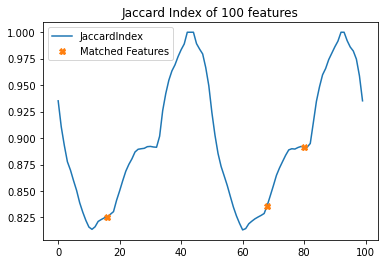

In [39]:
plt.plot(JI, label="JaccardIndex")
plt.plot([16,68,80],[JI[16], JI[68], JI[80]], marker="X", lw=0, label="Matched Features")
plt.legend(loc='best')
plt.title("Jaccard Index of 100 features")

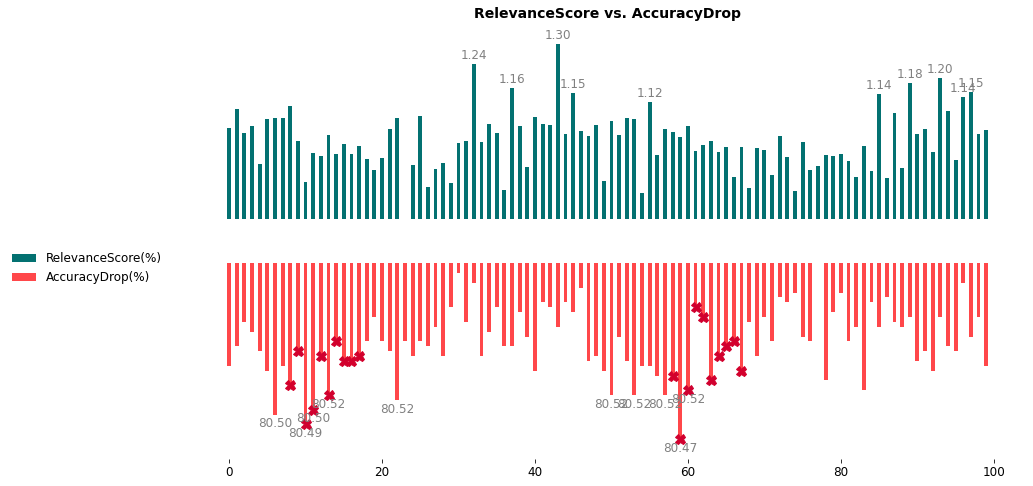

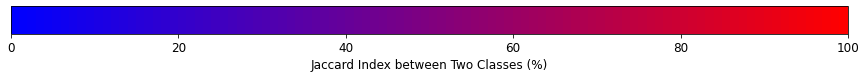

In [40]:
input_relevance_percentage = (relevance[0] / sum(relevance[0]))
MLCorrPlot2D(CorrList=np.array(JI), scoreA=input_relevance_percentage, scoreB=ADrop_train_avg, topN=10, isDrop=True, fullRank=True)

In [41]:
angles = np.linspace(0, 2*np.pi, 100)
angles.shape

(100,)

Text(0.5, 1.0, 'Matched features for 2D MLTSA Results')

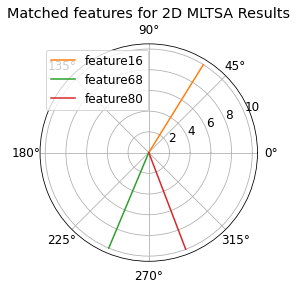

In [42]:
plt.polar(90, 10)
plt.plot([angles[16],angles[16]],[0,10],"-", label="feature16")
plt.plot([angles[68],angles[68]],[0,10],"-", label="feature68")
plt.plot([angles[80],angles[80]],[0,10],"-", label="feature80")
plt.legend(loc=2)
plt.title("Matched features for 2D MLTSA Results")